In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Bidirectional, LSTM, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

In [3]:
# === CONFIG === #
IMG_SIZE = 64
BATCH_SIZE = 32
EPOCHS = 20
DATASET_PATH = '/kaggle/input/hand-ges/leapGestRecog/'  # <-- corrected path

In [4]:
 #Function to create a "virtual dataset" with correct gesture grouping
def create_dataset_symlink(base_path='/kaggle/working/gesture_dataset_bilstm'):
    if not os.path.exists(base_path):
        os.makedirs(base_path)
        for person_folder in os.listdir(DATASET_PATH):
            person_path = os.path.join(DATASET_PATH, person_folder)
            if os.path.isdir(person_path):
                for gesture_folder in os.listdir(person_path):
                    gesture_path = os.path.join(person_path, gesture_folder)
                    if os.path.isdir(gesture_path):
                        target_folder = os.path.join(base_path, gesture_folder)
                        if not os.path.exists(target_folder):
                            os.makedirs(target_folder)
                        for img in os.listdir(gesture_path):
                            src_img = os.path.join(gesture_path, img)
                            dst_img = os.path.join(target_folder, f"{person_folder}_{img}")
                            os.symlink(src_img, dst_img)
    return base_path

# Build the symlink dataset
new_dataset_path = create_dataset_symlink()

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    new_dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    new_dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 16000 images belonging to 10 classes.
Found 4000 images belonging to 10 classes.


In [6]:
# === MODEL === #
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Reshape((14, 14 * 64)),  # (timesteps, features) for LSTM

    Bidirectional(LSTM(64, return_sequences=False)),

    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(train_gen.num_classes, activation='softmax')
])

In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 14, 896)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         492,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 529,226 (2.02 MB)

 Trainable params: 529,226 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# === TRAINING === #
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


500/500 ━━━━━━━━━━━━━━━━━━━━ 153s 288ms/step - accuracy: 0.5387 - loss: 1.2969 - val_accuracy: 0.8282 - val_loss: 0.5462
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 93s 185ms/step - accuracy: 0.9892 - loss: 0.0392 - val_accuracy: 0.9202 - val_loss: 0.3532
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 94s 186ms/step - accuracy: 0.9976 - loss: 0.0094 - val_accuracy: 0.8923 - val_loss: 0.3747
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 93s 185ms/step - accuracy: 0.9990 - loss: 0.0052 - val_accuracy: 0.8763 - val_loss: 0.4448
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 94s 187ms/step - accuracy: 0.9990 - loss: 0.0047 - val_accuracy: 0.8500 - val_loss: 0.6949
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 98s 194ms/step - accuracy: 0.9993 - loss: 0.0031 - val_accuracy: 0.9178 - val_loss: 0.3893
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 96s 191ms/step - accuracy: 0.9994 - loss: 0.0025 - val_accuracy: 0.8500 - val_loss: 0.6740
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 94s 187ms/step - accuracy: 0.9991 - loss: 0.0039 - va

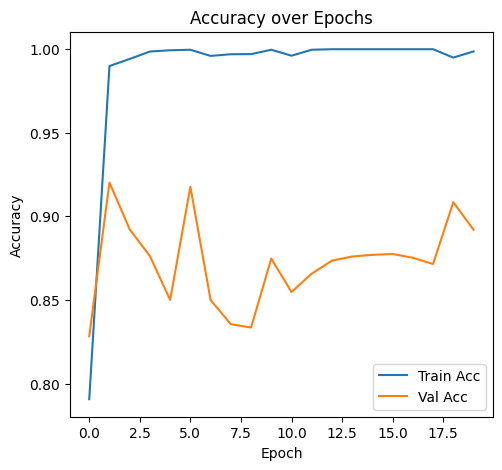

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# === ACCURACY & LOSS PLOTS === #
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

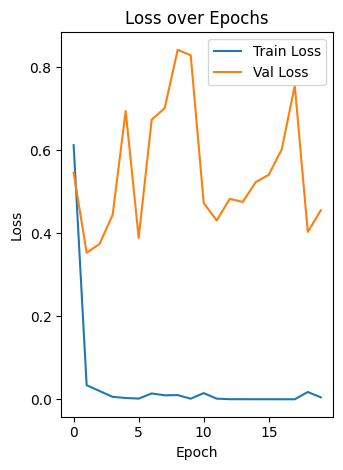

In [10]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 115ms/step


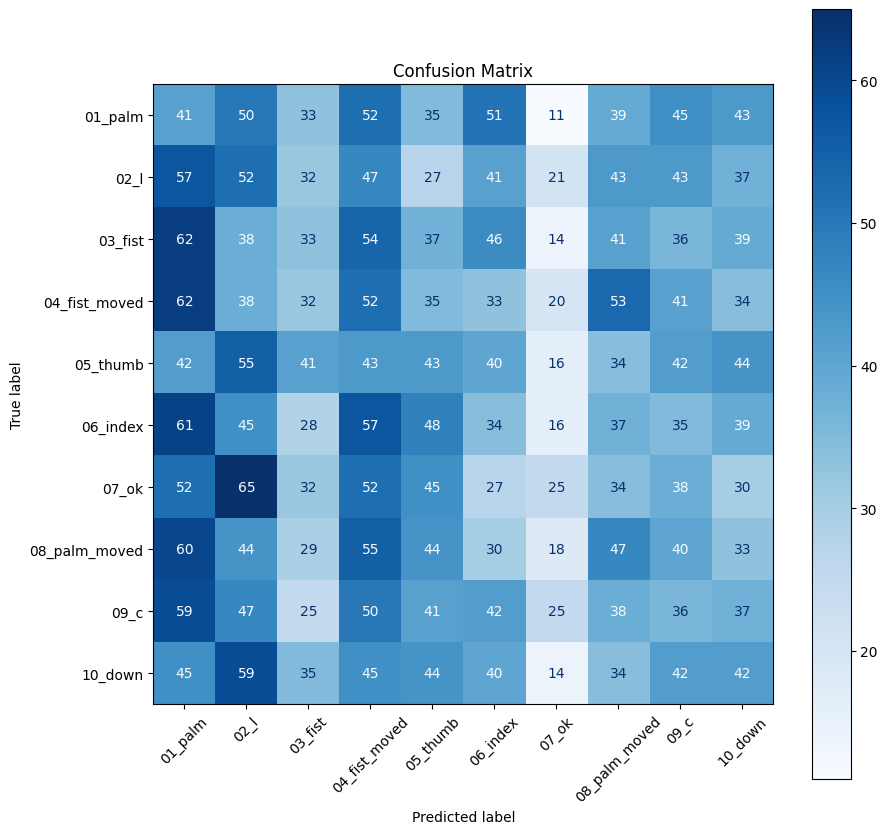

In [11]:
val_gen.reset()
Y_pred = model.predict(val_gen)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [12]:
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))


Classification Report:

               precision    recall  f1-score   support

      01_palm       0.08      0.10      0.09       400
         02_l       0.11      0.13      0.12       400
      03_fist       0.10      0.08      0.09       400
04_fist_moved       0.10      0.13      0.11       400
     05_thumb       0.11      0.11      0.11       400
     06_index       0.09      0.09      0.09       400
        07_ok       0.14      0.06      0.09       400
08_palm_moved       0.12      0.12      0.12       400
         09_c       0.09      0.09      0.09       400
      10_down       0.11      0.10      0.11       400

     accuracy                           0.10      4000
    macro avg       0.10      0.10      0.10      4000
 weighted avg       0.10      0.10      0.10      4000



In [13]:
# === PREDICTION FUNCTION === #

def predict_gesture_bilstm(img_path):
    gray_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    img_resized = cv2.resize(gray_img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)

    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)

    img_array = img_rgb.astype('float32') / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    class_idx = np.argmax(predictions[0])
    class_labels = list(train_gen.class_indices.keys())
    
    # Extract the proper gesture name
    predicted_label = '_'.join(class_labels[class_idx].split('_')[1:])  # handles cases like '08_palm_moved'

    print(f"Predicted gesture: {predicted_label}")

    display_img = cv2.resize(gray_img, (256, 256), interpolation=cv2.INTER_NEAREST)
    plt.figure(figsize=(6, 6), dpi=100)
    plt.imshow(display_img, cmap='gray', interpolation='nearest')
    plt.title(f"Prediction: {predicted_label}", fontsize=16)
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step
Predicted gesture: thumb


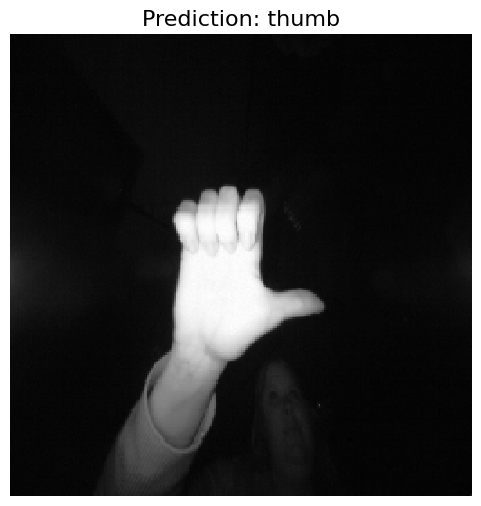

In [14]:
predict_gesture_bilstm('/kaggle/input/hand-ges/leapGestRecog/02/05_thumb/frame_02_05_0009.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted gesture: fist


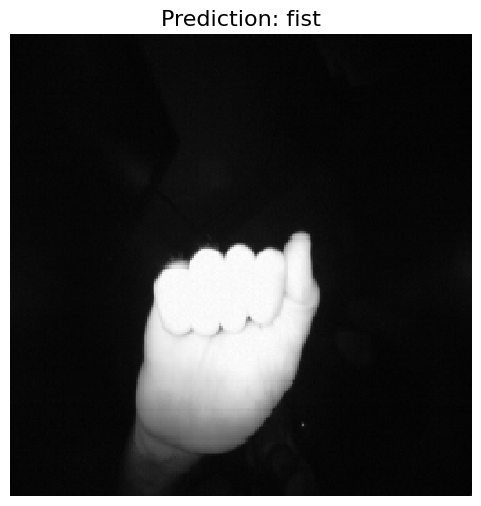

In [15]:
 predict_gesture_bilstm('/kaggle/input/hand-ges/leapGestRecog/06/03_fist/frame_06_03_0007.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted gesture: down


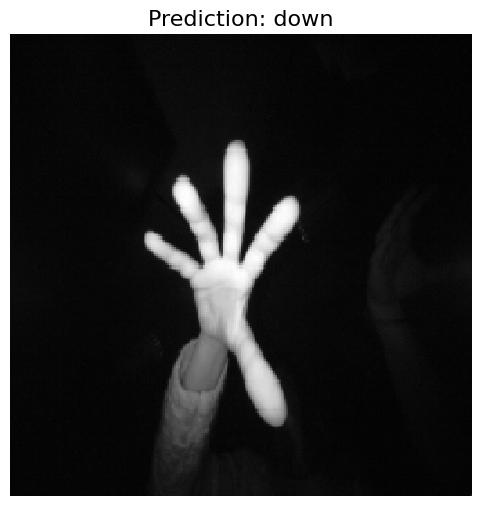

In [16]:
 predict_gesture_bilstm('/kaggle/input/hand-ges/leapGestRecog/07/10_down/frame_07_10_0019.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted gesture: thumb


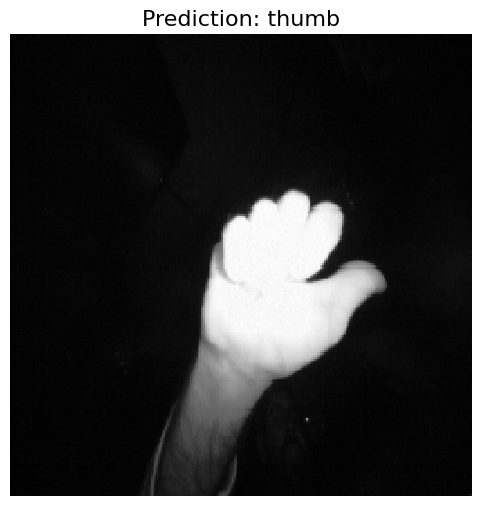

In [17]:
 predict_gesture_bilstm('/kaggle/input/hand-ges/leapGestRecog/04/05_thumb/frame_04_05_0018.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted gesture: palm_moved


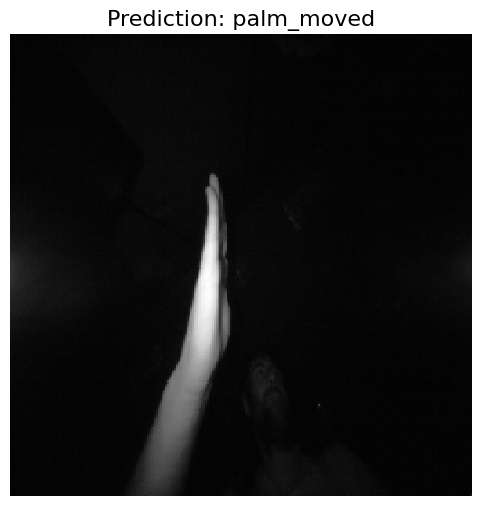

In [18]:
 predict_gesture_bilstm('/kaggle/input/hand-ges/leapGestRecog/03/08_palm_moved/frame_03_08_0015.png')